In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os

os.chdir('/content/drive/MyDrive/Colab Notebooks/4.2.2')

Mounted at /content/drive


[Data Generation] Sample 500/10000
[Data Generation] Sample 1000/10000
[Data Generation] Sample 1500/10000
[Data Generation] Sample 2000/10000
[Data Generation] Sample 2500/10000
[Data Generation] Sample 3000/10000
[Data Generation] Sample 3500/10000
[Data Generation] Sample 4000/10000
[Data Generation] Sample 4500/10000
[Data Generation] Sample 5000/10000
[Data Generation] Sample 5500/10000
[Data Generation] Sample 6000/10000
[Data Generation] Sample 6500/10000
[Data Generation] Sample 7000/10000
[Data Generation] Sample 7500/10000
[Data Generation] Sample 8000/10000
[Data Generation] Sample 8500/10000
[Data Generation] Sample 9000/10000
[Data Generation] Sample 9500/10000
[Data Generation] Sample 10000/10000
[Custom Init] Sine-based initialization done!
[Epoch 10/200] Loss: 0.2513
[Epoch 20/200] Loss: 0.2491
[Epoch 30/200] Loss: 0.2475
[Epoch 40/200] Loss: 0.2468
[Epoch 50/200] Loss: 0.2464
[Epoch 60/200] Loss: 0.2462
[Epoch 70/200] Loss: 0.2462
[Epoch 80/200] Loss: 0.2461
[Epoch 90/

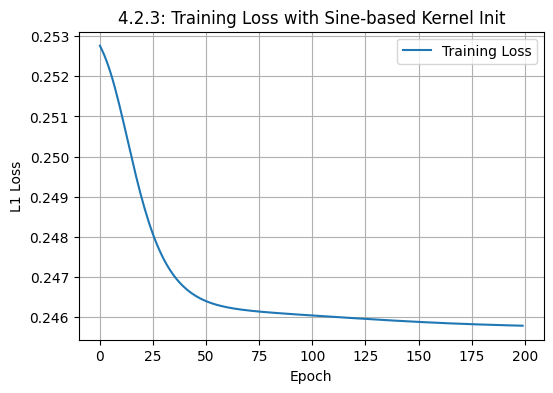

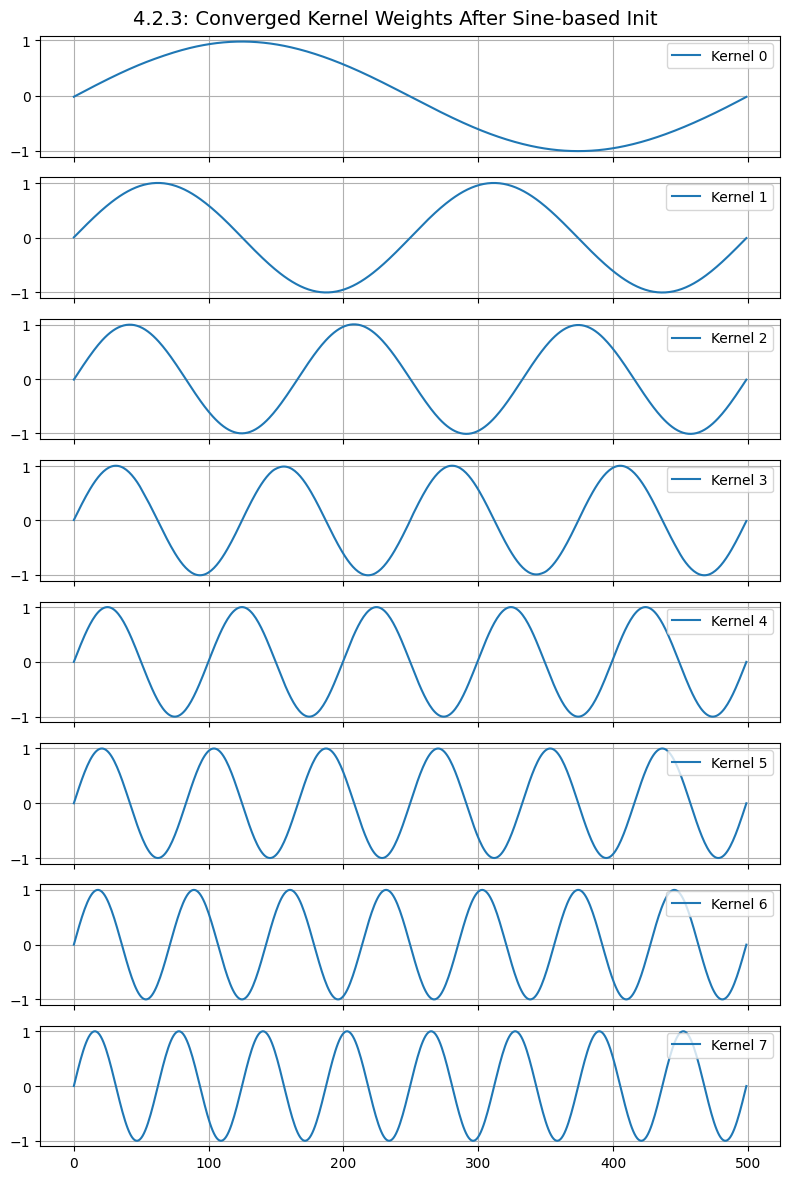

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.signal import detrend
from sklearn.utils import shuffle

###############################################################################
# (1) Data generation function (equivalent to training_data_generation.m)
###############################################################################
def rescale(array):
    """ In matlab, rescale(x) : the array is normalized to 0, 1. """
    mi, ma = array.min(), array.max()
    if abs(ma - mi) < 1e-9:
        return np.zeros_like(array)
    return (array - mi) / (ma - mi)

def generate_data_matlab_style(N=500, Xtot=10000, sl_multiplier=5):
    """
    Repeat the data generation logic of MATLAB training_data_generation.m:
    - Length of each signal is N*sl_multiplier (default: 2500)
    - For each signal, if y_tot==0, an all-1 sequence is generated; Otherwise generate one or more cosine signals and detrend.
    - The first 500 coefficients are counted using dct_ideal, and the first 8 coefficients are normalized as labels.
    """
    step = (2*np.pi)/N
    t = np.arange(step, 2*np.pi*sl_multiplier + step, step)  # Length = N*sl_multiplier
    length = N * sl_multiplier
    trainX = np.zeros((Xtot, length))
    trainy = np.zeros((Xtot, 8))

    for i in range(Xtot):
        if (i+1) % 500 == 0:
            print(f"[Data Generation] Sample {i+1}/{Xtot}")
        # noise = 0*randn(...)
        noise = np.zeros(length)
        # y_tot = randi([0,30],1)
        y_tot = np.random.randint(0, 31)
        dct_ideal = np.zeros(N)
        if y_tot == 0:
            y = np.ones(length)
            dct_ideal[0] = 1
        else:
            if y_tot > 2:
                y_tot = 1
            y = np.zeros(length)
            for _ in range(y_tot):
                f2 = np.random.randint(1, 8)
                dct_ideal[f2] += 1
                f = f2 / 2.0
                time_add = (2*np.pi)/np.random.randint(1,51)
                y += np.cos(f * (t + time_add))
            y = detrend(y)
        y = y + noise
        dct_ideal[0] *= 2

        trainX[i, :] = y
        trainy[i, :] = rescale(dct_ideal[:8])
    return trainX, trainy

###############################################################################
# (2) Define 1D CNN (MaxPool) for frequency classification
###############################################################################
class ConvNet1D_MaxPool(nn.Module):
    def __init__(self, kernel_size=500, out_channels=8, L_out=2001):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=out_channels,
                               kernel_size=kernel_size, padding=0)
        self.pool = nn.MaxPool1d(L_out)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # x: (batch, 1, 2500)
        out = self.conv1(x)         # -> (batch, 8, L_out)
        out = torch.abs(out)        # Spectral amplitude
        out = self.pool(out)        # -> (batch, 8, 1)
        out = out.view(out.size(0), -1)  # -> (batch, 8)
        out = self.softmax(out)
        return out

###############################################################################
# (3) Custom initialization Convolution kernel: Each kernel is initialized using a custom function
###############################################################################
def custom_init_function(model, kernel_size=500):
    """
    The eight cores of the convolution layer are initialized using custom functions.
    Here we choose to initialize with sinusoidal waves, and each convolution kernel uses sinusoidal waves of different frequencies as the starting value.

    Reasoning:
    - In the frequency decomposition task, the sine function forms the basis of Fourier and DCT,
    So using sine waves as initialization can provide a reasonable starting point for the network that is relevant to the task,
    Helps the network capture different frequency components faster.
    - At the same time, different nuclei use different frequencies, so that the convolution nuclei in the initial state have diversity, which is conducive to learning to distinguish each frequency feature of the signal.
    """
    weights_data = model.conv1.weight.data.cpu().numpy()  # shape: (8, 1, kernel_size)
    out_channels = weights_data.shape[0]
    for i in range(out_channels):
        # Set the frequency of each core: for example, frequency = 1 + i
        freq = 1 + i
        arr = np.sin(2 * np.pi * freq * np.linspace(0, 1, kernel_size))
        # reshape (1, kernel_size)
        arr_2d = arr.reshape((1, kernel_size))
        weights_data[i, 0, :] = arr_2d
    model.conv1.weight.data = torch.from_numpy(weights_data).float()
    print("[Custom Init] Sine-based initialization done!")

###############################################################################
# (4) Generate Data -> Build Network -> Custom Initialization -> Training -> Visualization
###############################################################################
def main():
    # A) Generate data
    N = 500
    Xtot = 10000
    sl_multiplier = 5
    trainX, trainy = generate_data_matlab_style(N=N, Xtot=Xtot, sl_multiplier=sl_multiplier)
    trainX, trainy = shuffle(trainX, trainy)

    # Change to Torch tensor
    trainXT = torch.from_numpy(trainX.astype('float32')).unsqueeze(1)  # shape: (Xtot, 1, 2500)
    trainyT = torch.from_numpy(trainy.astype('float32'))               # shape: (Xtot, 8)

    # B) Define net
    kernel_size = 500
    L_in = trainX.shape[1]            # 2500
    L_out = L_in - kernel_size + 1    # 2001
    model = ConvNet1D_MaxPool(kernel_size=kernel_size, out_channels=8, L_out=L_out)

    # C) The custom initialization convolution kernel: using sine wave, each nuclear different frequency
    custom_init_function(model, kernel_size=kernel_size)

    # D) Training parameters
    num_epochs = 200
    batch_size = 30
    learning_rate = 1e-6
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # E) 50 epochs
    Ndata = trainXT.shape[0]
    loss_list = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for i in range(0, Ndata, batch_size):
            x_batch = trainXT[i:i+batch_size, :, :]
            y_batch = trainyT[i:i+batch_size, :]
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / (Ndata // batch_size)
        loss_list.append(avg_loss)
        if (epoch+1) % 10 == 0:
            print(f"[Epoch {epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}")

    # F) Plot training loss curves
    plt.figure(figsize=(6,4))
    plt.plot(loss_list, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('L1 Loss')
    plt.title('4.2.3: Training Loss with Sine-based Kernel Init')
    plt.grid(True)
    plt.legend()
    plt.show()

    # G) Plot a training loss curve
    kernels = model.conv1.weight.detach().cpu().numpy()  # shape: (8, 1, kernel_size)
    fig, axs = plt.subplots(8, 1, figsize=(8,12), sharex=True)
    fig.suptitle('4.2.3: Converged Kernel Weights After Sine-based Init', fontsize=14)
    for i in range(8):
        axs[i].plot(kernels[i,0,:], label=f'Kernel {i}')
        axs[i].legend(loc='upper right')
        axs[i].grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
